parameters from the paper

In [1]:
import numpy as np
import visualkeras as vk 

from keras import Model
from keras.models import load_model
from keras.optimizers import gradient_descent_v2
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Conv2DTranspose, concatenate
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.utils import shuffle

train_data = np.load("../datasets/Amharic character Image dataset/Type-II/train_char/X_train_char.npy")
test_data = np.load("../datasets/Amharic character Image dataset/Type-II/test_char/X_test_char.npy")
train_labels = np.load("../datasets/Amharic character Image dataset/Type-II/train_char/y_train_char.npy")
test_labels = np.load("../datasets/Amharic character Image dataset/Type-II/test_char/y_test_char.npy")

# Normalization 

train_data = train_data / 255.0
test_data = test_data / 255.0

# Changing the old labels to row-column

# training labels
train_labels_row = []
train_labels_col = []

for label in train_labels:
    row, col = divmod(label, 7)
    train_labels_row.append(row)
    train_labels_col.append(col)

train_labels_row = np_utils.to_categorical(train_labels_row)
train_labels_col = np_utils.to_categorical(train_labels_col)

# test labels
test_labels_row = []
test_labels_col = []

for label in test_labels:
    row, col = divmod(label, 7)
    test_labels_row.append(row)
    test_labels_col.append(col)

test_labels_row = np_utils.to_categorical(test_labels_row)
test_labels_col = np_utils.to_categorical(test_labels_col)


In [16]:
# Changing the old labels to row-column

# training labels
train_labels_row = []
train_labels_col = []

for label in train_labels:
    row, col = divmod(label, 7)
    train_labels_row.append(row)
    train_labels_col.append(col)

train_labels_row = np_utils.to_categorical(train_labels_row)
train_labels_col = np_utils.to_categorical(train_labels_col)

# test labels
test_labels_row = []
test_labels_col = []

for label in test_labels:
    row, col = divmod(label, 7)
    test_labels_row.append(row)
    test_labels_col.append(col)

test_labels_row = np_utils.to_categorical(test_labels_row)
test_labels_col = np_utils.to_categorical(test_labels_col)

print(train_labels_row.shape, train_labels_col.shape, test_labels_row.shape, test_labels_col.shape, sep='\n')

(70194, 33)
(70194, 7)
(7800, 33)
(7800, 7)


In [2]:
# Model

# feature extraction UNET

input = Input(train_data.shape[1:])

conv1 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (input)
conv1 = Dropout(rate=0.1) (conv1)
conv1 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
maxpool1 = MaxPool2D(pool_size=2) (conv1)
conv2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool1)
conv2 = Dropout(rate=0.1) (conv2)
conv2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
maxpool2 = MaxPool2D(pool_size=2) (conv2)
conv3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool2)
conv3 = Dropout(rate=0.1) (conv3)
conv3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv3)

upconv4 = Conv2DTranspose(32, 2, strides=2, padding='same') (conv3)
upconv4 = concatenate(inputs=[upconv4, conv2])
conv4 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv4)
conv4 = Dropout(rate=0.1) (conv4)
conv4 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv4)
upconv5 = Conv2DTranspose(16, 2, strides=2, padding='same') (conv4)
upconv5 = concatenate(inputs=[upconv5, conv1])
conv5 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv5)
conv5 = Dropout(rate=0.1) (conv5)
conv5 = Conv2D(16, 3, activation='relu', kernel_initializer='he_normal', padding='same') (conv5)
extractor_output = MaxPool2D(pool_size=2) (conv5) # breaks the symmetricity

# classification multi-task learing CNN 

flatten = Flatten() (extractor_output)
fc1 = Dense(512, activation='relu') (flatten)
fc2 = Dense(512, activation='relu') (fc1)                   # neurons?

row = Dense(units=33, activation='softmax', name='row') (fc2)
col = Dense(units=7, activation='softmax', name='col') (fc2)

model = Model(inputs=input, outputs=[row, col], name='FCNN')

model.compile(
    optimizer='adam',
    loss=[
        'categorical_crossentropy', 
        'categorical_crossentropy'  
    ], 
    loss_weights = None,
    metrics=['accuracy']
) 

In [3]:
# Combined accuracy metrics

class CombinedMetric(Callback):
    def __init__(self):
        super(CombinedMetric, self).__init__()

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        logs['accuracy'] = (logs["row_accuracy"] + logs["col_accuracy"]) / 2
        logs['val_accuracy'] = (logs["val_row_accuracy"] + logs["val_col_accuracy"]) / 2

In [4]:
callbacks = [
    ModelCheckpoint(
        filepath="../datasets/Amharic character Image dataset/models/fcnn-arct/paper_best_loss_model.h5",
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min"
    ),

    ModelCheckpoint(
        filepath="../datasets/Amharic character Image dataset/models/fcnn-arct/paper_best_val_loss_model.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False, 
        mode="min"
    ),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 10
    ),

    TensorBoard(
        log_dir="../datasets/Amharic character Image dataset/models/fcnn-arct"
    ),

    CombinedMetric()
]

In [5]:
history = model.fit(
    train_data,
    [train_labels_row, train_labels_col],
    validation_data=(test_data, [test_labels_row,test_labels_col]), 
    epochs=100, 
    batch_size=256, 
    callbacks=[callbacks]
)

Epoch 1/100
275/275 [==============================] - 16s 40ms/step - loss: 1.9823 - row_loss: 1.1551 - col_loss: 0.8272 - row_accuracy: 0.7014 - col_accuracy: 0.7072 - val_loss: 0.5839 - val_row_loss: 0.2861 - val_col_loss: 0.2979 - val_row_accuracy: 0.9301 - val_col_accuracy: 0.9121 - accuracy: 0.7043 - val_accuracy: 0.9211
Epoch 2/100
275/275 [==============================] - 10s 35ms/step - loss: 0.4591 - row_loss: 0.2258 - col_loss: 0.2333 - row_accuracy: 0.9413 - col_accuracy: 0.9309 - val_loss: 0.4082 - val_row_loss: 0.1940 - val_col_loss: 0.2142 - val_row_accuracy: 0.9485 - val_col_accuracy: 0.9371 - accuracy: 0.9361 - val_accuracy: 0.9428
Epoch 3/100
275/275 [==============================] - 10s 38ms/step - loss: 0.3192 - row_loss: 0.1529 - col_loss: 0.1663 - row_accuracy: 0.9589 - col_accuracy: 0.9488 - val_loss: 0.3698 - val_row_loss: 0.1835 - val_col_loss: 0.1864 - val_row_accuracy: 0.9535 - val_col_accuracy: 0.9444 - accuracy: 0.9539 - val_accuracy: 0.9489
Epoch 4/100
2

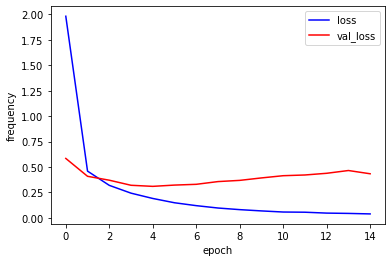

In [6]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

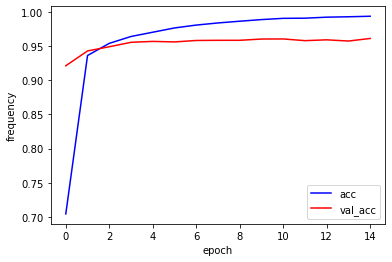

In [7]:
plt.plot(history.history["accuracy"], 'b', label="acc")
plt.plot(history.history["val_accuracy"], 'r', label="val_acc")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [8]:
model = load_model("../datasets/Amharic character Image dataset/models/fcnn-arct/paper_best_val_loss_model.h5")

loss, _, _, row_acc, col_acc = model.evaluate(test_data, [test_labels_row,test_labels_col], verbose=False)

print('row_accuracy: {:5.4f}%'.format(100 * row_acc))
print('col_accuracy: {:5.4f}%'.format(100 * col_acc))
print()
print('accuracy: {:5.4f}%'.format(100 * (row_acc + col_acc)/2))
print('val_loss: {:5.4f}%'.format(100 * loss))

row_accuracy: 96.0641%
col_accuracy: 95.2821%

accuracy: 95.6731%
val_loss: 30.9231%


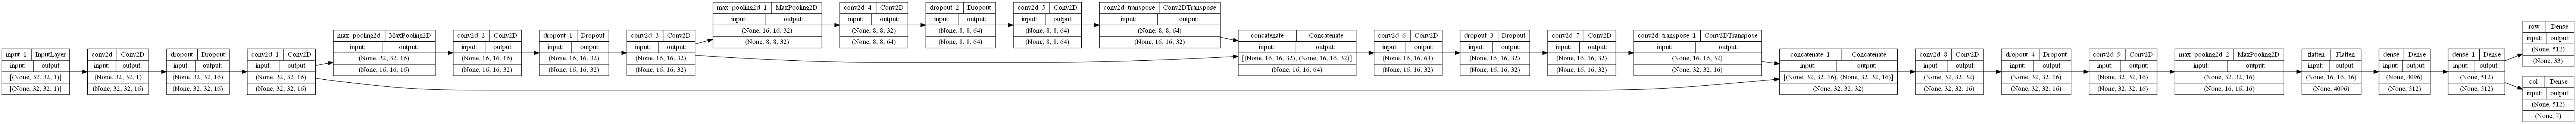

In [15]:
plot_model(
    model,
    to_file="../datasets/Amharic character Image dataset/models/fcnn-arct/multi_input_and_output_model.png",
    show_shapes=True,
    rankdir="LR" #TB LR for vertical
)